In [1]:
# known: all data + parameters except kapc
# unknown: kapc

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow as tf
import models_tf as models

In [14]:
data = sio.loadmat("../../data/data_2k_points.mat")
c0 = data["IC"]
t = data["t"]
c_ref = data["y"]

t_train = t

scale = np.array(
    [10, 1, 100, 100, 0.0001, 10, 0.1, 1000]
).reshape([-1])
c_ref = c_ref / scale
c0 = c0 / scale

In [15]:
np.max(data["y"], axis=0)

array([2.59399416e+01, 3.54133207e+00, 8.57923329e+02, 1.00000000e+03,
       1.14212936e-03, 3.84436903e+01, 8.68846177e-01, 2.16754273e+03])

In [25]:
model = models.PINN(
    c0=c0,
    output_dim=8,
    scale=scale,
    units=100, 
    activation=tf.tanh,
    eps=1e-4,
)

In [26]:
t_ode = t_train[::10]
t_u = t_train
u = c_ref
loss, data_loss, ode_loss = model.train(t_ode, t_u, u, niter=60000, lam=1)

0 2097.6611
1000 1.5502474
2000 1.1100428
3000 1.0353837
4000 0.9318835
5000 0.86361265
6000 0.78661823
7000 0.68288165
8000 0.60617733
9000 0.555022
10000 0.5148821
11000 0.48572502
12000 0.46929806
13000 0.4709202
14000 0.4511376
15000 0.44324887
16000 0.4827698
17000 0.4547956
18000 0.41932866
19000 0.37657696
20000 0.10739772
21000 0.033414233
22000 0.013344381
23000 0.0066644866
24000 0.0035342895
25000 0.0030499692
26000 0.001327391
27000 0.00076587417
28000 0.00039081843
29000 0.0032172946
30000 0.0151365325
31000 0.00010793275
32000 0.00033993437
33000 0.00093018805
34000 9.071083e-05
35000 0.0001282353
36000 0.00013101344
37000 0.00074891234
38000 7.982255e-05
39000 0.00056121405
40000 0.00076315337
41000 9.535535e-05
42000 0.00072629255
43000 0.00022175738
44000 6.648832e-05
45000 6.637441e-05
46000 0.00021716597
47000 0.00081495533
48000 6.288586e-05
49000 0.0004449209
50000 7.846027e-05
51000 2.541122e-05
52000 0.00015438275
53000 7.2358394e-05
54000 0.00030271013
55000 0.0

In [27]:
model.restore()
c_pred = model.call(
    tf.constant(t_train, tf.float32),
)

In [28]:
L2 = np.sqrt(np.sum((c_pred - c_ref) ** 2, axis=0) / np.sum(c_ref ** 2, axis=0))

In [29]:
L2

array([0.00114254, 0.00173034, 0.00153992, 0.00066525, 0.00946789,
       0.00216583, 0.00037334, 0.0015126 ])

In [35]:
print(tf.math.exp(model.log_k_apc))

tf.Tensor(0.0014063693, shape=(), dtype=float32)


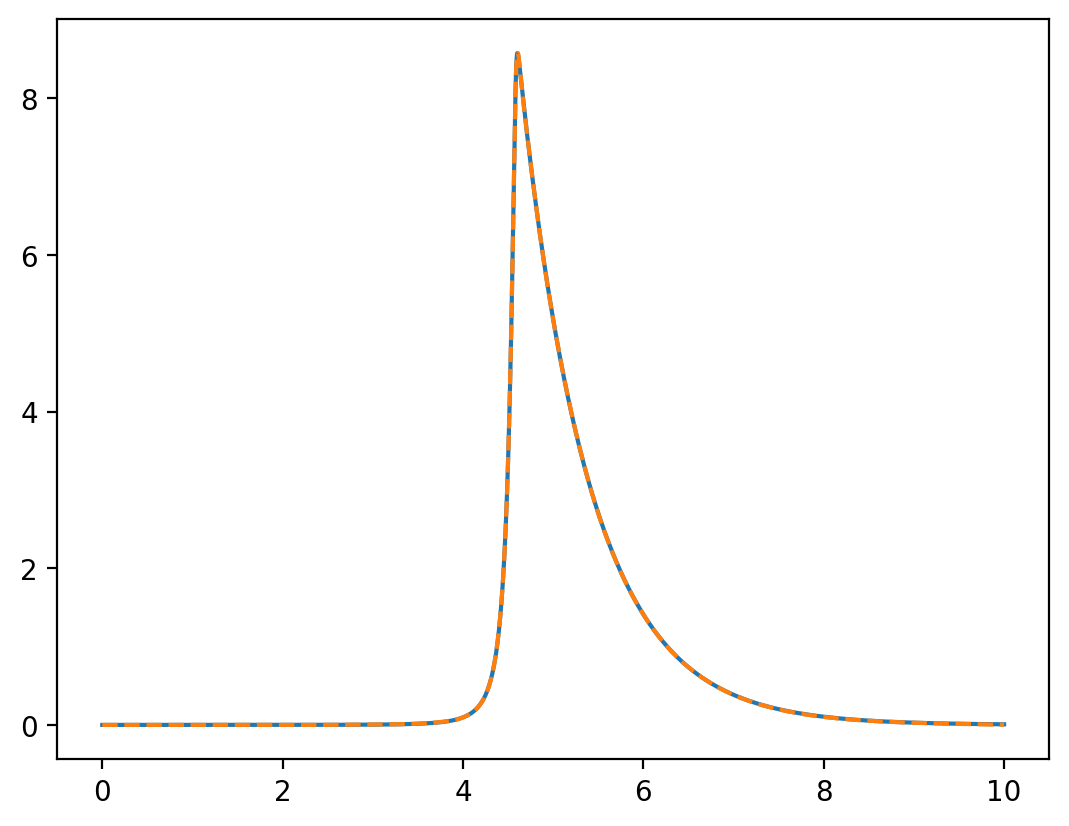

In [31]:
j = 2
plt.figure(dpi=200)
plt.plot(t_train, c_ref[:, j], "-", label="reference")
# plt.plot(t_train, y_train, '.', label="train")
plt.plot(t_train, c_pred[:, j], "--", label="prediction")
# plt.legend()
plt.show()

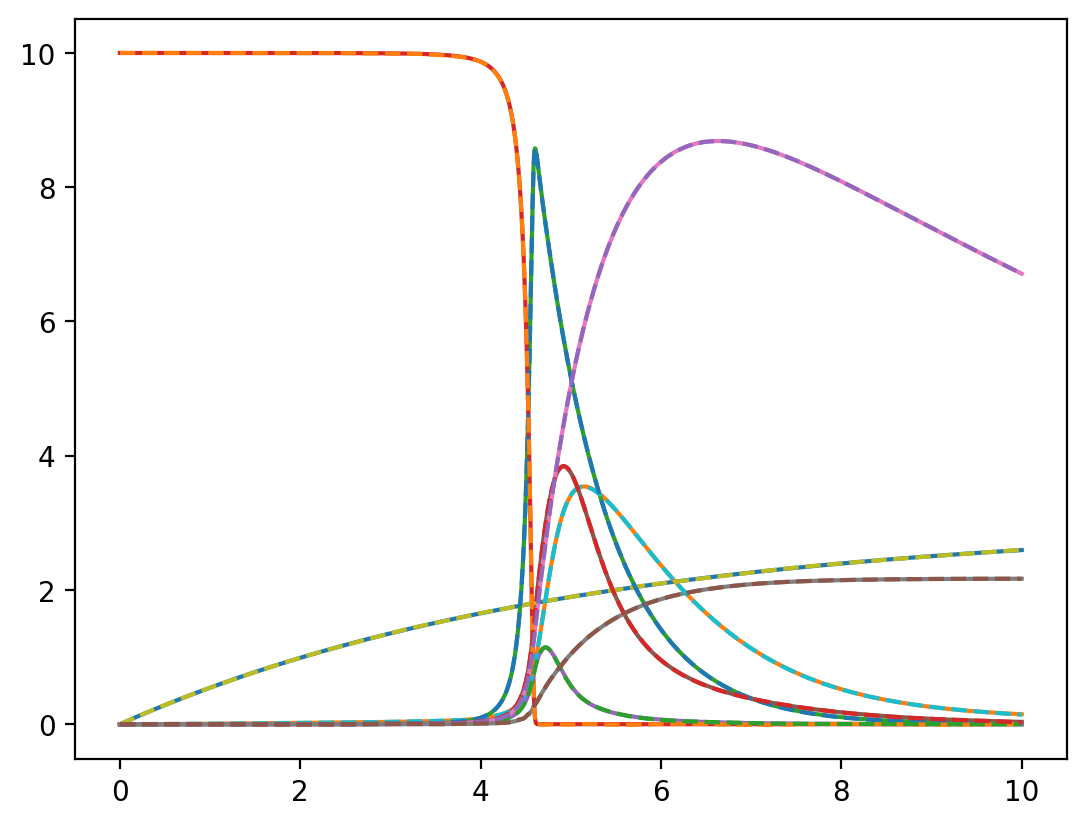

In [32]:
plt.figure(dpi=200)
plt.plot(t_train, c_ref, "-", label="reference")
# plt.plot(t_train, y_train, '.', label="train")
plt.plot(t_train, c_pred, "--", label="prediction")
# plt.legend()
plt.show()

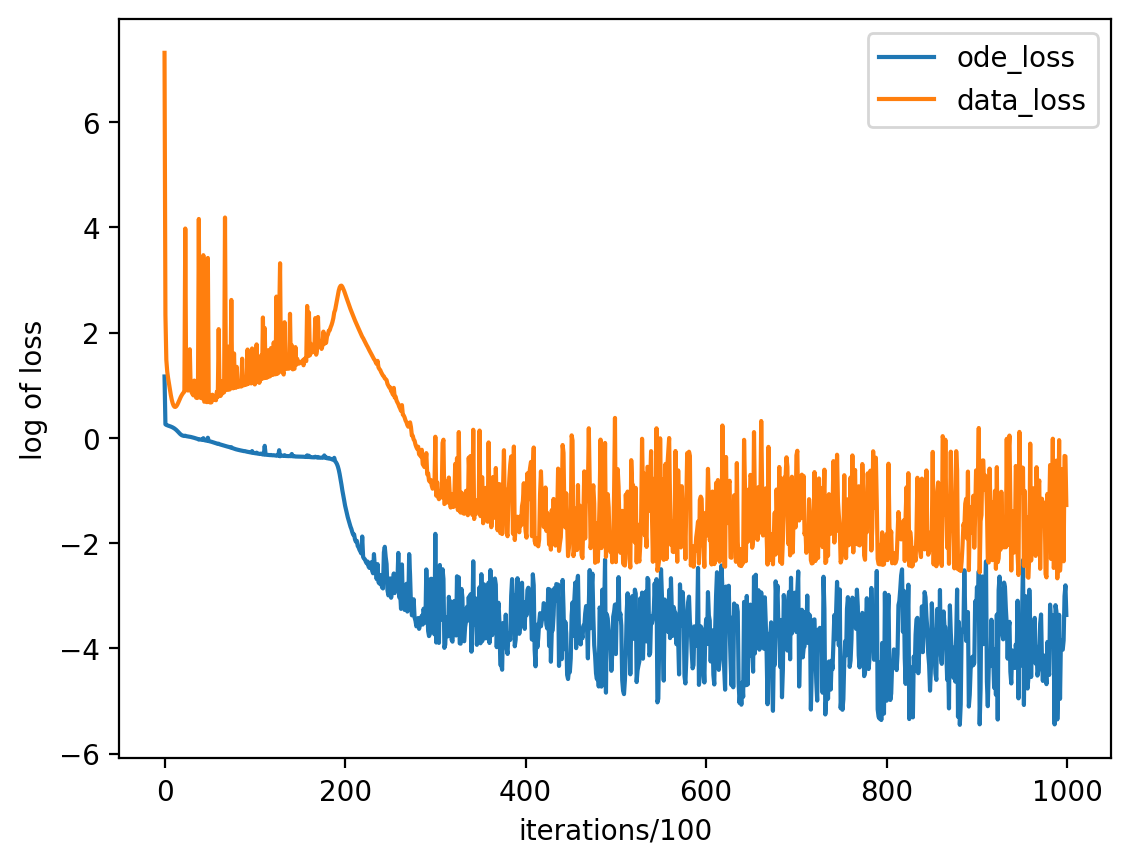

In [33]:
plt.figure(dpi=200)
plt.plot(np.log10(ode_loss)[::100], "-", label="ode_loss")
plt.plot(np.log10(data_loss)[::100], "-", label="data_loss")
# plt.plot(np.log(loss), "-", label="loss")
plt.xlabel('iterations/100')
plt.ylabel('log of loss')
plt.legend()
plt.show()

In [38]:
kapc_pred = []
for i in range(10):
    kapc_pred += [sio.loadmat("output/kapc-{}.mat".format(str(i)))["k_apc"][0][0]]
kapc_pred = np.array(kapc_pred)

In [39]:
kapc_ref = np.array([0.0014] * 10)
lams = [1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 0.0]
lams

[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 0.0]

In [40]:
kapc_err = np.subtract(kapc_pred, kapc_ref)
kapc_err

array([-8.46628599e-05,  2.22301707e-06, -5.30416481e-06,  1.33732930e-06,
        4.97717075e-06, -2.49087214e-06,  1.76981222e-06,  6.72714226e-07,
        2.01232173e-07, -6.04223795e-06])

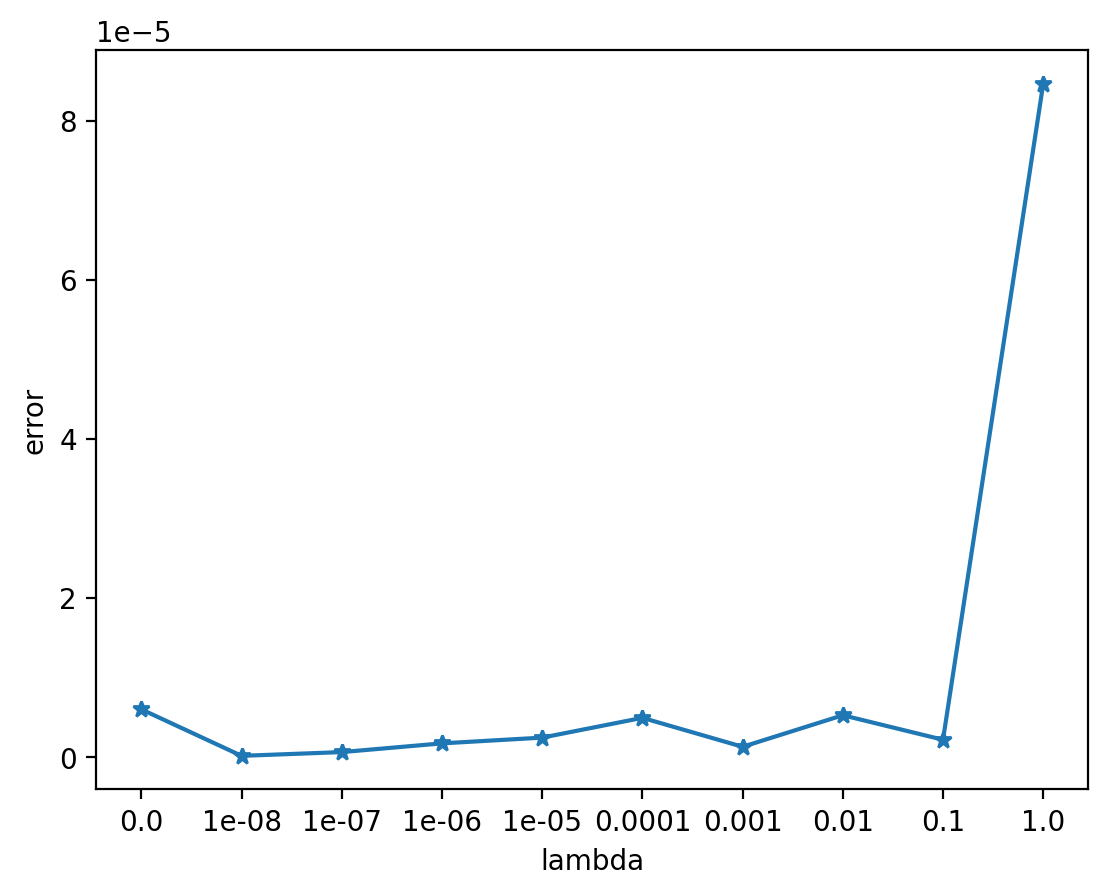

In [41]:
plt.figure(dpi=200)
x = [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
plt.plot(x, np.abs(kapc_err), '-*')
_ = plt.xticks(x, lams)
plt.xlabel('lambda')
plt.ylabel('error')
plt.show()

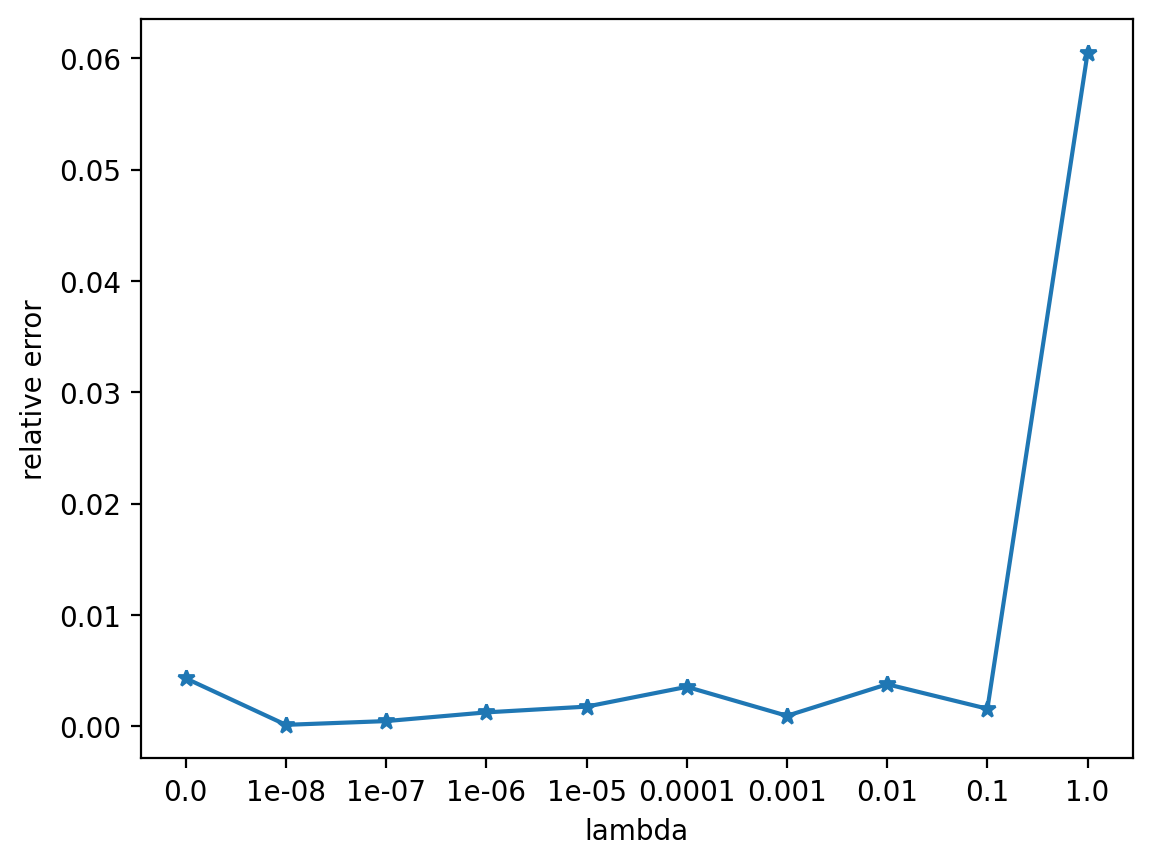

In [42]:
plt.figure(dpi=200)
x = [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
plt.plot(x, np.abs(np.divide(kapc_err, kapc_ref)), '-*')
_ = plt.xticks(x, lams)
plt.xlabel('lambda')
plt.ylabel('relative error')
plt.show()